In [28]:
from tqdm import tqdm_notebook
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import umap
import os
from scipy.spatial.distance import pdist, cdist
from sklearn.cluster import DBSCAN, MeanShift
from sklearn.metrics import silhouette_score, \
                            davies_bouldin_score, \
                            pairwise_distances, \
                            confusion_matrix, \
                            f1_score, \
                            accuracy_score, \
                            make_scorer, \
                            calinski_harabasz_score

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors, KernelDensity
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap
from sklearn.datasets import make_blobs, make_moons, make_circles
# %matplotlib notebook
import matplotlib.pyplot as plt
from itertools import combinations
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D 
import multiprocessing
from joblib import Parallel, delayed
from utils import filter_paths, NPR, clustering, unpack_data
np.random.seed(42)
from lightgbm import LGBMClassifier

In [132]:
X,y = data_dict['moons']
nn = NearestNeighbors(n_neighbors=5)
nn.fit(X)
neigh_dist, neigh_ind = nn.kneighbors(X)
s = []
y1,y2 = [0,1]
dist_C0 = neigh_dist[:,1:][y==y1].min(1)
dist_C1 = neigh_dist[:,1:][y==y2].min(1)
cdist_C = cdist(X[y==y1], X[y==y2])
cdist_C0 = cdist_C.min(axis=1)
cdist_C1 = cdist_C.min(axis=0)
s0 = (dist_C0/cdist_C0).mean()
s1 = (dist_C1/cdist_C1).mean()
s.append((s0 + s1)/2)

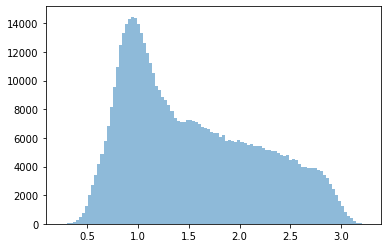

In [133]:
plt.hist(cdist_C.flatten(), bins=100, alpha=0.5)
# plt.hist(dist_C1, bins=100, alpha=0.5)
# plt.hist(cdist_C0, bins=100, alpha=0.5)
# plt.hist(cdist_C1, bins=100, alpha=0.5)
plt.show()

In [127]:
def nearest_ratio_score(X,y, n_neighbors=5):
    nn = NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(X)
    neigh_dist, neigh_ind = nn.kneighbors(X)
    s = []
    for y1,y2 in list(combinations(np.unique(y),2)):
        dist_C0 = neigh_dist[:,1:][y==y1].min(1)
        dist_C1 = neigh_dist[:,1:][y==y2].min(1)
        cdist_C = cdist(X[y==y1],X[y==y2]).min()
#         cdist_C0 = cdist_C.min(axis=1)
#         cdist_C1 = cdist_C.min(axis=0)
        s0 = (dist_C0/cdist_C).mean()
        s1 = (dist_C1/cdist_C).mean()
        s.append((s0 + s1)/2)
    return np.mean(s)

# Toy example

In [128]:
np.random.seed(0)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500

data_dict = {'circles': make_circles(n_samples=n_samples, factor=.5,noise=.05),
             'moons': make_moons(n_samples=n_samples, noise=.05),
             'blobs': make_blobs(n_samples=n_samples, random_state=8)}

no_structure = np.random.rand(n_samples, 2)
y_no_structure = (no_structure[:,0] > no_structure.mean()).astype(int)
data_dict['uniform'] = [no_structure, y_no_structure]

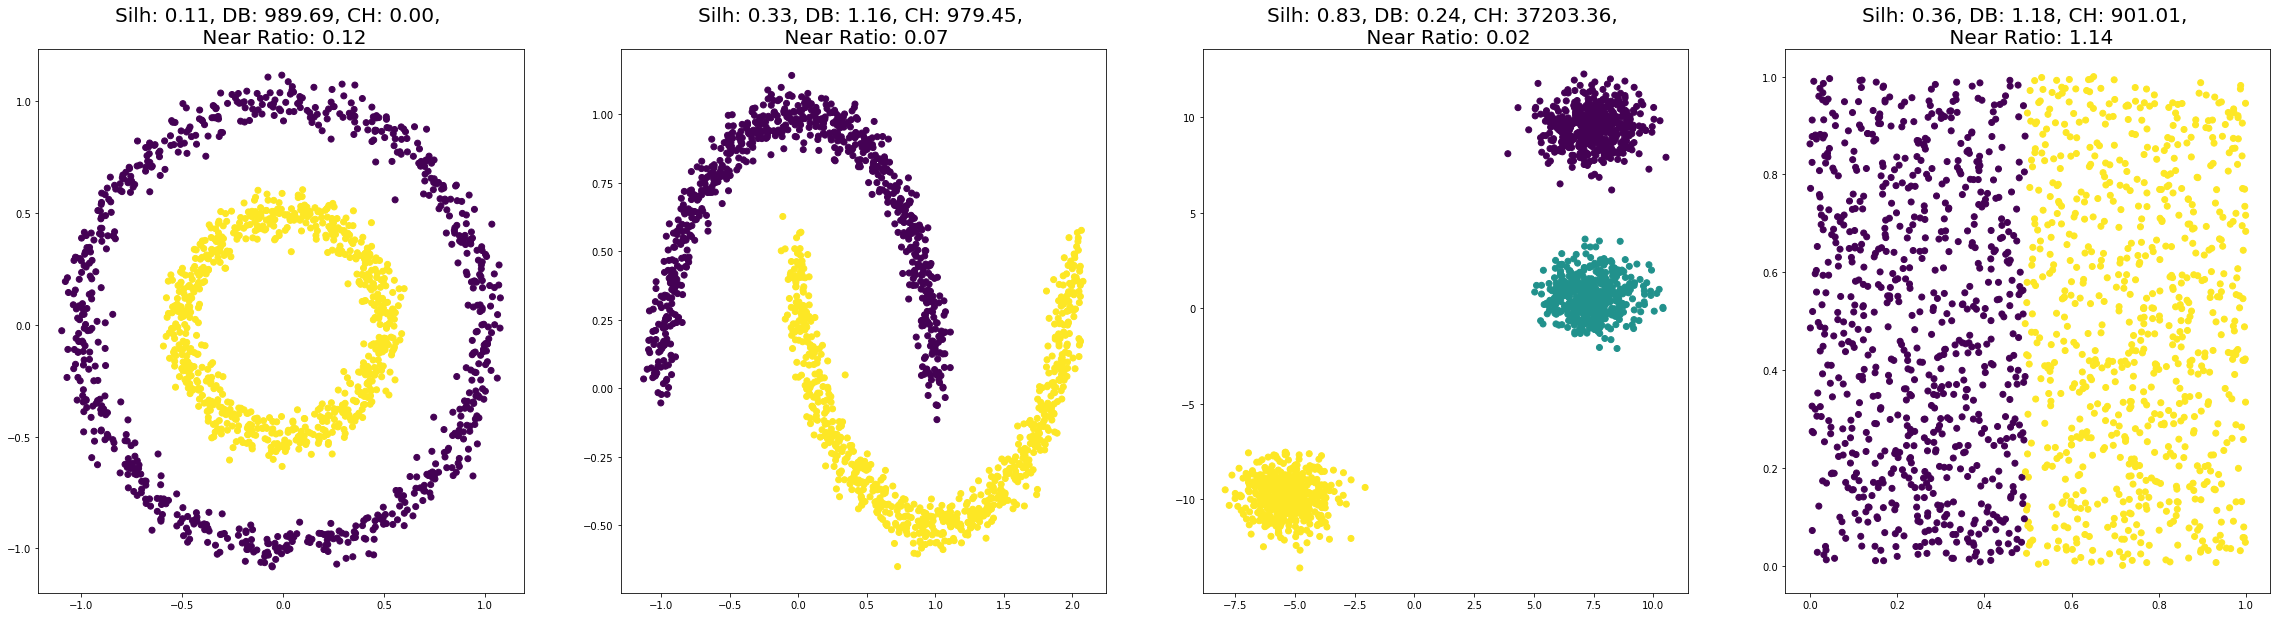

In [129]:
fig, axes = plt.subplots(ncols=len(data_dict), figsize=(len(data_dict)*10, 10))
for i,(k,v) in enumerate(data_dict.items()):
    x,y = v
    db = davies_bouldin_score(x,y)
    sh = silhouette_score(x,y)
    ch = calinski_harabasz_score(x,y)
    nr = nearest_ratio_score(x,y)
    
    sh = "{:.2f}".format(sh)
    db = "{:.2f}".format(db)
    ch = "{:.2f}".format(ch)
    nr = "{:.2f}".format(nr)
    
    axes[i].scatter(x[:,0], x[:,1], c=y)
    axes[i].set_title(f'Silh: {sh}, DB: {db}, CH: {ch}, \n Near Ratio: {nr}', fontsize=20)
plt.show()

# Generate data

In [2]:
# paths to the databases containing the PCA and Isomap projections 
root = './separate_datasets_transformed/'
root_pca = './separate_datasets_proj/'
DATASETS = ['AGP_proj_o', 'ptb_proj_o']
N_DATASETS = len(DATASETS)

paths = filter_paths([os.path.join(root,path) for path in os.listdir(root)], keywords=DATASETS)
paths_pca = filter_paths([os.path.join(root_pca,path) for path in os.listdir(root_pca)], keywords=DATASETS)
paths_mf_lle = filter_paths(paths, keywords=['lle'])
paths_mf_isomap = filter_paths(paths, keywords=['isomap'])

In [3]:
data_pca = unpack_data(paths_pca)
data_lle = unpack_data(paths_mf_lle)
data_isomap = unpack_data(paths_mf_isomap)
# data_ae = unpack_data(paths_mf_ae)

In [4]:
# X,y = data_pca['ibd_proj_o'], None
# X,y = make_blobs(n_samples=1000, n_features=2, centers=np.array([[5,5],[-5,5], [0,-5]]))
# plt.scatter(X[:,0],X[:,1], c=y)
# plt.show()

In [5]:
X = data_isomap['AGP_proj_o']

# Estimate distribution

In [7]:
N,d = X.shape

In [8]:
list(combinations(range(d),2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 4),
 (2, 5),
 (3, 4),
 (3, 5),
 (4, 5)]

In [180]:
p95_list = get_neigh_perc(X)
DBSCAN_PARAMS = [min(p95_list), max(p95_list)]

In [181]:
eps = np.mean(DBSCAN_PARAMS)

In [192]:
DBSCAN_PARAMS

[0.06636415641348863, 0.127389576089063]

In [197]:
X_sample = kde.sample(n_samples=1000, random_state=42)

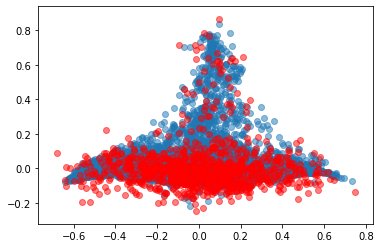

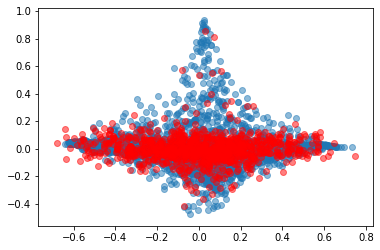

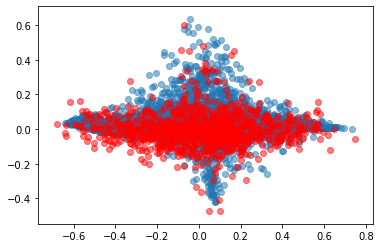

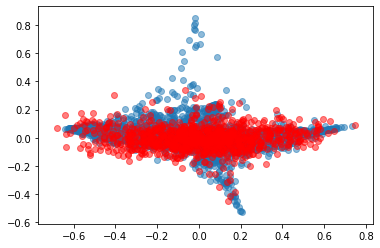

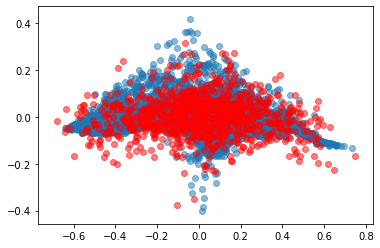

In [198]:
for i,j in list(combinations(range(d),2))[:5]:
    plt.show()
    plt.scatter(X[:,i],X[:,j], alpha=0.5)
    plt.scatter(X_sample[:,i],X_sample[:,j], color='r', alpha=0.5)
    plt.show()

# Spurious clusters visualization

In [6]:
root_sep_trans = './separate_datasets_transformed/'
paths_tsne_separate = [os.path.join(root_sep_trans, path) for path in os.listdir(root_sep_trans)]
name = 'AGP_proj_o_tsne'
paths_tsne_separate = list(filter(lambda x: name in x.split('/')[-1].split('.')[0], paths_tsne_separate))
data_transformed3d_merged = { p.split('/')[-1].split('.')[0]:np.load(p, allow_pickle=True) for p in paths_tsne_separate}
X_tsne = data_transformed3d_merged[name]

In [7]:
tsne_p95_list = get_neigh_perc(X_tsne)
TSNE_DBSCAN_PARAMS = [min(tsne_p95_list), max(tsne_p95_list)]

In [8]:
TSNE_DBSCAN_PARAMS

[0.8213195265697741, 1.9196755368892475]

In [31]:
# sort_index_z = np.argsort(X_tsne[:,2])
# sort_index_y = np.argsort(X_tsne[:,1])
# wicked_index = np.concatenate([sort_index_z[:400], sort_index_y[2000:2200], sort_index_z[-300:]])

z_upper_mask = (X_tsne[:,2] < 20) * (X_tsne[:,2] > 15)
z_lower_mask = (X_tsne[:,2] > -5) * (X_tsne[:,2] < 10) * (X_tsne[:,0] < -10) * (X_tsne[:,1] < -10)
z_mean_mask = (X_tsne[:,2] < -2) * (X_tsne[:,0] > 5) * (X_tsne[:,1] > 5) * (X_tsne[:,2] > -6)

mask = (z_upper_mask + z_lower_mask + z_mean_mask).astype(bool)

X_tsne_chosen = X_tsne[mask]

In [32]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.8).fit(X_tsne_chosen)
X_tsne_sample = kde.sample(n_samples=100, random_state=42)

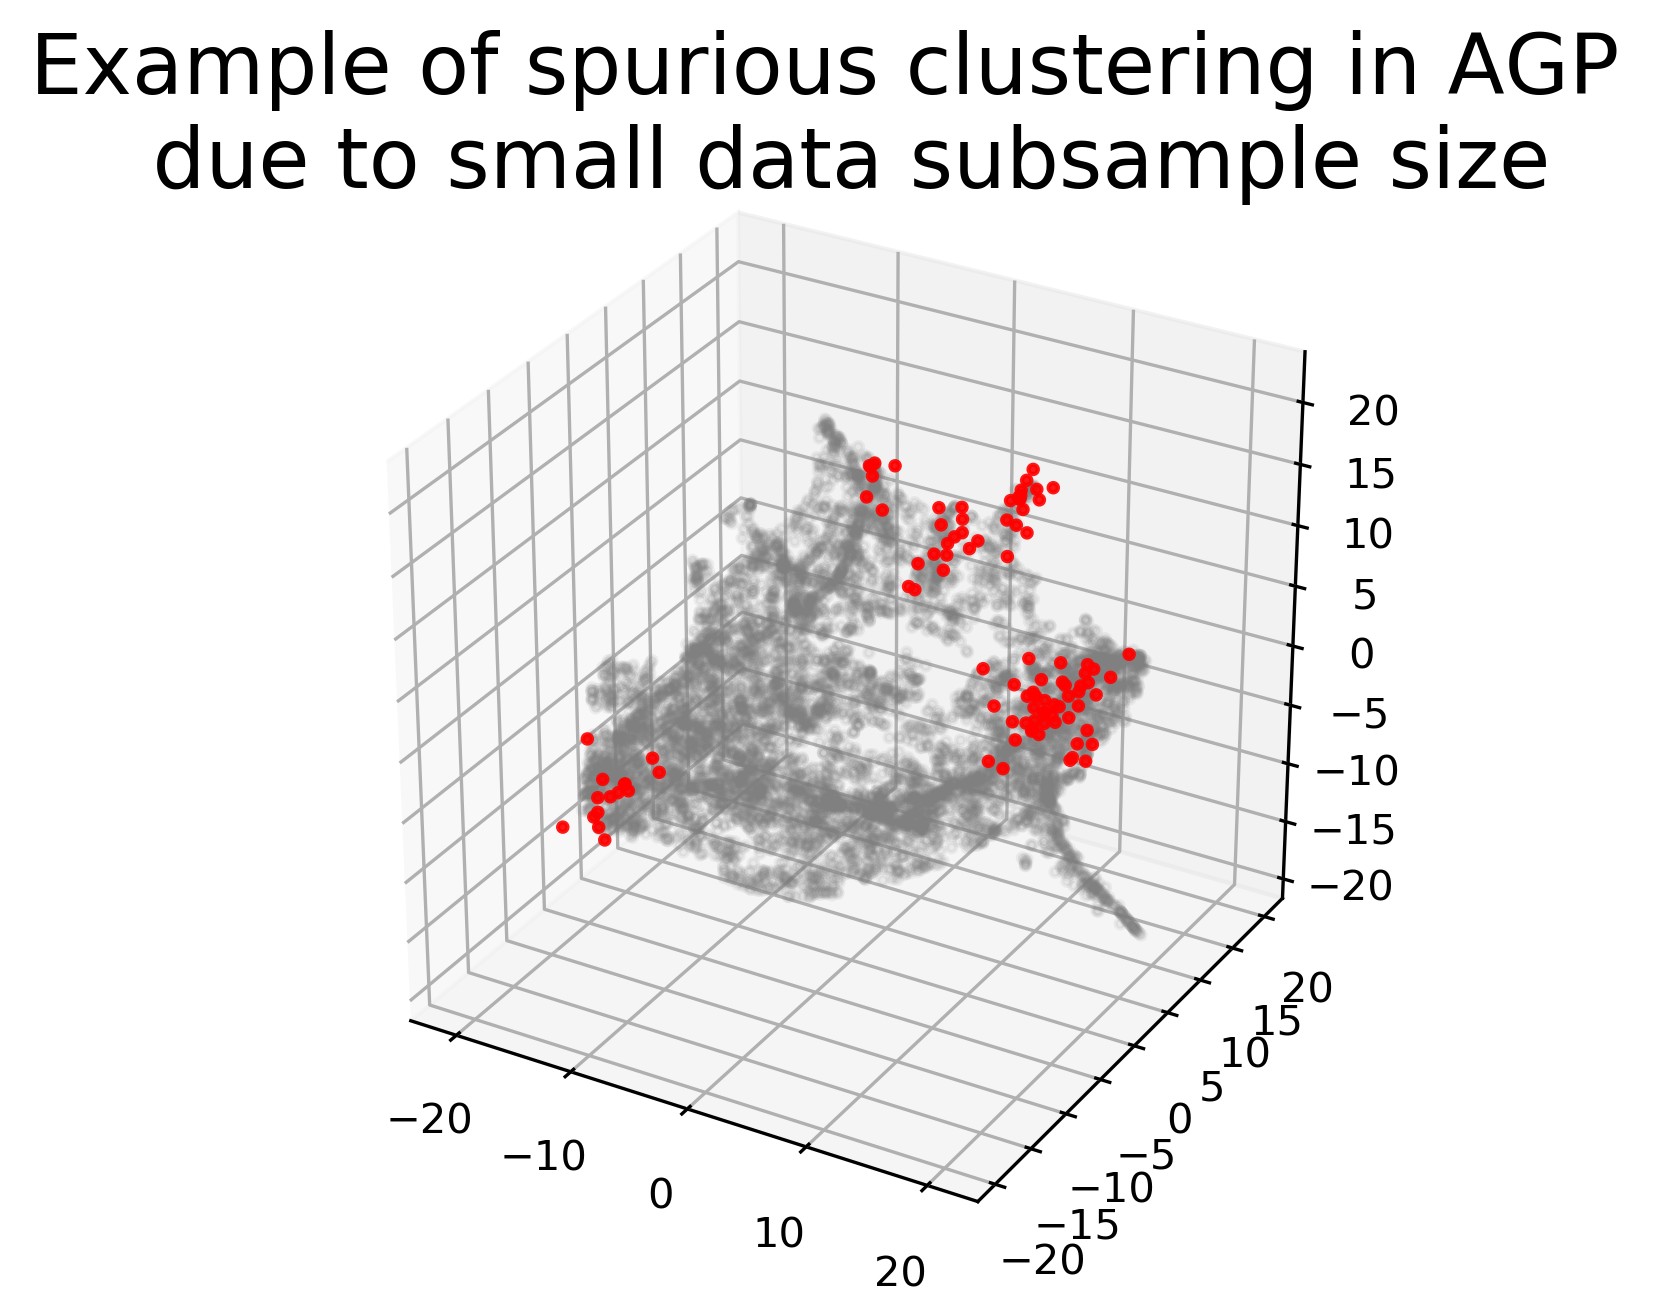

In [33]:
fig = plt.figure(figsize=(5,5), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(X_tsne[:,0], X_tsne[:,1], X_tsne[:,2], marker='.', color='gray', alpha=0.1)
ax.scatter(X_tsne_sample[:,0], X_tsne_sample[:,1], X_tsne_sample[:,2], marker='.', color='r', alpha=0.9)
ax.set_title(f'Example of spurious clustering in AGP \n due to small data subsample size', fontsize=20, pad=10)
    
#     handles, labels = scatter.legend_elements(alpha=0.8)
#     plt.legend(handles, labels, loc="upper right")
# lgnd = plt.legend() 
# for lm in lgnd.legendHandles:
#     lm.set_alpha(0.9)
plt.show()

# Number of clusters distribution

In [199]:
def make_best_prediction(method, X, param_range):
    best_silh = -np.inf
    best_pred = 1
    for param in param_range:
        m = method(eps=param, n_jobs=-1)
        pred = m.fit_predict(X)
        n_clust = len(np.unique(pred[pred != -1]))
        if n_clust > 1:
            silh = silhouette_score(X, pred)
        else:
            silh = -np.inf
        if silh > best_silh:
            best_silh = silh
            best_pred = n_clust
        
    return best_pred

In [200]:
sample_times = 50
results = {}
sample_size_range = np.arange(50,N//2,100)
param_range = np.linspace(*DBSCAN_PARAMS,num=5)

for sample_size in tqdm_notebook(sample_size_range):
    metrics = defaultdict(list)
    for i in range(sample_times):
        samples = kde.sample(n_samples=sample_size)
        best_pred = make_best_prediction(DBSCAN, samples, param_range)
#         metrics['samples'].append(samples)
#         metrics['preds'].append(pred)
#         if best_m is not None:
        metrics['n_clust'].append(best_pred)
#         metrics['noise_ratio'].append(sum(pred == -1)/len(pred))
    results[sample_size] = metrics

In [201]:
# for k,r in results.items():
#     plt.figure()
#     plt.title(k)
#     plt.hist(r['n_clust'])
#     plt.show()

In [204]:
def entropy(x, support=None):
#     bins = len(np.unique(x))
    pdf = np.histogram(x, bins=np.concatenate([support, [max(support)+1]]), density=True, range=(min(support), max(support)))[0]
    H = -np.sum(pdf*np.log(pdf+1e-5))
    return H

clusters = np.array([r['n_clust'] for r in results.values()])
support = np.unique(clusters.flatten())
clusters_H = [entropy(r['n_clust'], support) for r in results.values()]

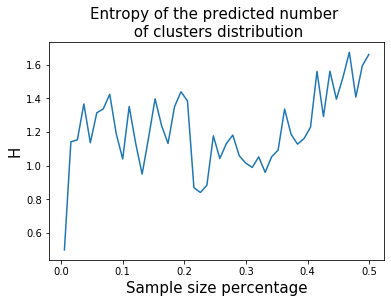

In [205]:
plt.plot(sample_size_range/N, clusters_H)
plt.title('Entropy of the predicted number \n of clusters distribution', fontsize=FONTSIZE)
plt.xlabel('Sample size percentage', fontsize=FONTSIZE)
plt.ylabel('H', fontsize=FONTSIZE)
plt.show()

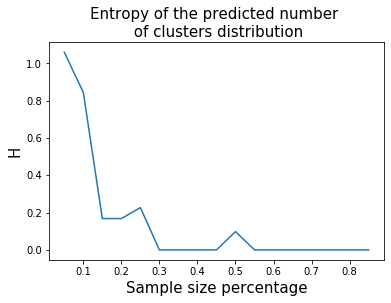

In [170]:
# plt.plot(sample_size_range/N, clusters_H)
# plt.title('Entropy of the predicted number \n of clusters distribution', fontsize=FONTSIZE)
# plt.xlabel('Sample size percentage', fontsize=FONTSIZE)
# plt.ylabel('H', fontsize=FONTSIZE)
# plt.show()

# Silhoette\DB-index distribution

In [68]:
# sample_times = 50
# results = []
# preds = []
# for i in tqdm_notebook(range(sample_times)):
#     samples = kde.sample(n_samples=100, random_state=i)

#     cluster_results, cluster_preds = clustering({'data':X}, 
#                                                 KMeans, 
#                                                 np.arange(2, 10, 1), 
#                                                 dbscan=False, 
#                                                 dbscan_params_dict=None)
#     results.append(cluster_results)
#     preds.append(cluster_preds)
# clear_output()

In [69]:
results_dbind = np.array([[v[0] for k,v in r['data'].items()] for r in results])
results_silh = np.array([[v[1] for k,v in r['data'].items()] for r in results])

In [70]:
V_total_dbind = results_dbind.var(0).sum()
V_total_silh = results_silh.var(0).sum()
V_total = V_total_dbind + V_total_silh

In [71]:
V_total

0.004948856823002167

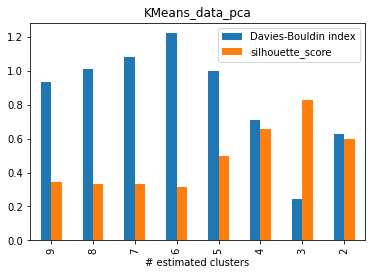

In [43]:
plot_proj_clustering(results[0], method='pca', suptitle='KMeans')